## Step1: Create a sample dataset for model development and local code debug

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    "../credentials/tokopedia-970.json",
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [2]:
sql = """
SELECT full_name as name, CASE WHEN sex=1 THEN 'm' 
                               WHEN sex=2 THEN 'f' 
                          END as gender ,
                          FARM_FINGERPRINT(CAST(create_date AS STRING)) as hashdate
FROM `tokopedia-970.voyager_dwh.bi_dim_user` 
WHERE sex=1 or sex=2"""

In [3]:
# Added the RAND() so that we can now subsample from each of the hashdates to get approximately the record counts we want
trainQuery = "SELECT * FROM (" + sql + ") WHERE ABS(MOD(hashdate, 4)) < 3 AND RAND() < 0.0005"
evalQuery = "SELECT * FROM (" + sql + ") WHERE ABS(MOD(hashdate, 4)) = 3 AND RAND() < 0.0005"
traindf = client.query(trainQuery).to_dataframe()
evaldf = client.query(evalQuery).to_dataframe()
print("There are {} examples in the train dataset and {} in the eval dataset".format(len(traindf), len(evaldf)))

There are 18080 examples in the train dataset and 6325 in the eval dataset


In [4]:
traindf.head()

,name,gender,hashdate
0,eka nur,f,-8142140688890279093
1,mery andriani,f,996617937683627357
2,Ina Aprilia,f,9034066141447301174
3,Yudi Dyah,f,-4062936282218272378
4,Dian Patrisia,f,5636367441591355417


In [5]:
traindf.isna().sum()

name        0
gender      0
hashdate    0
dtype: int64

In [6]:
evaldf.isna().sum()

name        0
gender      0
hashdate    0
dtype: int64

In [7]:
traindf.to_csv("../data/train.csv", index=False)
evaldf.to_csv("../data/eval.csv", index=False)

## Step2: Build a distributable tensorflow data preprocessing pipeline and model

In [1]:
import string
import tensorflow as tf
import tensorflow_transform as tft
import numpy as np
tf.enable_eager_execution()
print(tf.__version__)

LETTERS = " " + string.ascii_lowercase
VOCAB = "../VOCAB"
EMBEDDING = 256
filter_size=100

1.15.0


In [2]:
def dynamic_padding(inp, min_size):
    # https://stackoverflow.com/questions/42334646/tensorflow-pad-unknown-size-tensor-to-a-specific-size
    pad_size = min_size - tf.shape(inp)[0]
    paddings = [[0, pad_size]] # Pad behind the name with spaces to align with padding from to_tensor default_value
    return tf.pad(inp, paddings, mode="CONSTANT", constant_values=" ") # 32 is the UTF-8 value for space

def x_preprocess(x):
    x_processed = tf.strings.lower(x)
    try:
        x_processed = tf.strings.unicode_split(x_processed, input_encoding="UTF-8").to_tensor(default_value=" ") #TODO: in TF2.0 can add an argument shape=[batch_size,100] to do padding/pruning here
    except:
        x_processed = tf.strings.unicode_split(x_processed, input_encoding="UTF-8")
    
    # Pad only if necessary
    x_processed = tf.cond(tf.less(tf.shape(x_processed)[1], filter_size), 
                          true_fn=lambda: tf.map_fn(lambda inp_name: dynamic_padding(inp_name, filter_size), x_processed), 
                          false_fn=lambda: tf.map_fn(lambda inp_name: tf.slice(inp_name, tf.constant([0]), tf.constant([100])), x_processed))
    
    #x_processed = tft.apply_vocabulary(x_processed, VOCAB, default_value=0)
    
    x_processed = tf.strings.unicode_decode(x_processed, 'UTF-8')-96 # make a=1
    x_processed = tf.map_fn(lambda item: (tf.map_fn(lambda subitem: 0 if (subitem[0]<0 or subitem[0]>26) else subitem[0], item)), 
                            x_processed.to_tensor())
    
    return x_processed

def preprocess(x, y):
    """tf.data compatible preprocessing"""
    x_processed = x_preprocess(x)
    y_processed = tf.cast(tf.equal(y, "m"), dtype=tf.int32)#tf.cond(tf.equal(y, "f"), lambda: 0.0, lambda: 1.0)

    return x_processed, y_processed

In [3]:
def _parse_function(proto):
    # tfrecord format definiton
    keys_to_features = {"name": tf.io.FixedLenFeature([], tf.string),
                        "gender": tf.io.FixedLenFeature([], tf.string)}
    
    # Load batch examples
    parsed_features = tf.io.parse_example(proto, keys_to_features)
    
    x = parsed_features["name"]
    y =  parsed_features["gender"]
       
    return x, y

In [4]:
# Read data
def csv_reader_dataset(filepaths, repeat=1, n_readers=8, n_read_threads=8, shuffle_buffer_size=1000, n_parse_threads=8, batch_size=32):
    """Read sharded csv files, preprocess, shuffle and create batches using tf.data API"""
    dataset = tf.data.Dataset.list_files(filepaths)

    # creat a tfdataset from the csv file
    defs = [tf.constant(["NaN"], dtype=tf.string)]*2
    dataset = dataset.interleave(lambda filepath: tf.data.experimental.CsvDataset(filepath, defs, select_cols=[0,1], header=True), 
                                 cycle_length=n_readers, num_parallel_calls=n_read_threads)

    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat()
    return dataset.batch(batch_size).prefetch(1)

In [5]:
def tfrecord_reader_dataset(filepaths, repeat=1, n_readers=8, n_read_threads=8, shuffle_buffer_size=1000, n_parse_threads=8, batch_size=32):
    dataset = (tf.data.Dataset
               .list_files(filepaths)
               .interleave(tf.data.TFRecordDataset, 
                           cycle_length=tf.data.experimental.AUTOTUNE, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .shuffle(shuffle_buffer_size).repeat()
               .batch(batch_size, drop_remainder=True)
               .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
               .prefetch(tf.data.experimental.AUTOTUNE)
              )
    
    return dataset

In [6]:
# Model
def build_dnn_model():
    """Construct model using tf.keras API"""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(len(LETTERS), EMBEDDING, input_length=100, name="embedding"))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128), name="bi-lstm"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))  
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model

In [7]:
# Mirrored Strategy to distribute training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_dnn_model()

# Check the model architecture
print(model.summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 256)          6912      
_________________________________________________________________
bi-lstm (Bidirectional)      (None, 256)               394240    
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 401,409
Trainable params: 401,409
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Step3: Train and Evaluate

In [9]:
TRAIN_BATCH_SIZE = 512
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 1000 # enough to get a reasonable sample, but not so much that it slows down
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

#train_set = csv_reader_dataset("../data/train*.csv", batch_size=TRAIN_BATCH_SIZE)
#eval_set = csv_reader_dataset("../data/eval*.csv", batch_size=NUM_EVAL_EXAMPLES).take(NUM_EVAL_EXAMPLES)

train_set = tfrecord_reader_dataset("../data/nonzip/toko_names_train*.tfrecord", batch_size=TRAIN_BATCH_SIZE)
eval_set = tfrecord_reader_dataset("../data/nonzip/toko_names_val*.tfrecord", batch_size=NUM_EVAL_EXAMPLES).take(NUM_EVAL_EXAMPLES)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
def show_batch(dataset):
    for batch in dataset.take(3):
        print(batch)
        
show_batch(train_set)

(<tf.Tensor: id=2302, shape=(512, 100), dtype=int32, numpy=
array([[ 7, 18,  5, ...,  0,  0,  0],
       [16, 21, 16, ...,  0,  0,  0],
       [ 9, 23,  1, ...,  0,  0,  0],
       ...,
       [18,  9,  6, ...,  0,  0,  0],
       [20, 15, 11, ...,  0,  0,  0],
       [19,  1, 14, ...,  0,  0,  0]], dtype=int32)>, <tf.Tensor: id=2303, shape=(512,), dtype=int32, numpy=
array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [11]:
history = model.fit(train_set, validation_data=eval_set, epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch)

Train for 19 steps, validate for 19 steps
Epoch 1/5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
18/19 [===========================>..] - ETA: 2s - loss: 0.6252 - acc: 0.6603INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
19/19 [========================

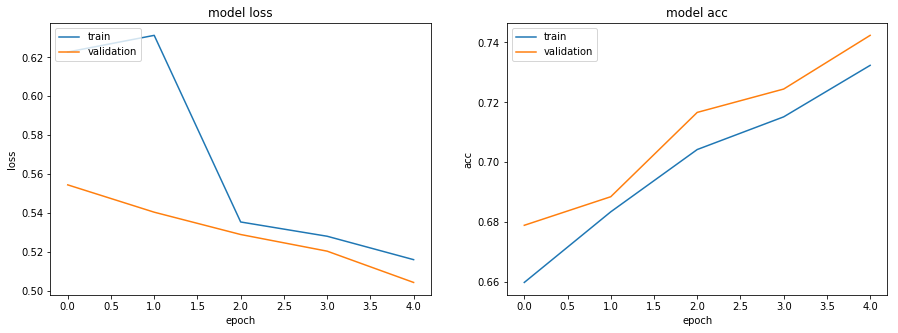

In [13]:
# plot the loss curve
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(15, 5))

for idx, key in enumerate(['loss', 'acc']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

In [14]:
########################
sample_data = tf.reshape(x_preprocess(["marie stephen leo"]), [1, 100])
model.predict(sample_data)
########################
# no matter what the input, the output is the same. something is wrong. - fixed
# The char to num process might be interfering with the embedding as that is the only difference from previous. - that's right 
# See if can change back the char tokenization to be from 0-26 instead of UTF-8 code - done

array([[0.5839907]], dtype=float32)

In [15]:
sample_data = tf.reshape(x_preprocess(["shilpa"]), [1, 100])
model.predict(sample_data)

array([[0.43350604]], dtype=float32)

In [16]:
model.predict(eval_set)

array([[0.57537735],
       [0.621277  ],
       [0.8282542 ],
       ...,
       [0.9744523 ],
       [0.70362693],
       [0.567532  ]], dtype=float32)

In [15]:
# TODO: Convert from csv to tfrecords for input - Done
# TODO: Refactor for Training job submission - Done
# TODO: Train on all data - Done
# TODO: Deploy serving API in AI Platform - Doesnt work as py_function in preprocessing cannot be served. Need to change to completely using tf.data API
# TODO: Convert py_function preprocessing to tf.data - Done
# TODO: tf.data char to num function update to give out 0 to 26 instead of utf-8 code. - Done
## this is to fix the issue where the model's predicted output is always the same number indicating the model did not learn anything
# TODO: Update the tf.data char to num function to fix very slow data processing during distributed learning - Done
# TODO: Update the tf.data char to num function removing tft.apply_vocab as it was throwing error while saving the model with signatures - Done

# TODO: Hyperparameter tuning
# TODO: Use ML Platform code and update the training code
# TODO: Deploy new serving API in AI Platform
# TODO: Kubeflow setup for regular retrainings